# Shor's Algorithm

Shor’s algorithm is famous for factoring integers in polynomial time. Since the best-known classical algorithm requires greater-than-polynomial time to factor the product of two primes, the widely used cryptographic protocol, RSA, relies on factoring being impossible for large enough integers.

In this chapter we will focus on the quantum part of Shor’s algorithm, which actually solves the problem of period finding. Since a factoring problem can be turned into a period finding problem in polynomial time, an efficient period finding algorithm can be used to factor integers efficiently too. For now its enough to show that if we can compute the period of 
 efficiently, then we can also efficiently factor. Since period finding is a worthy problem in its own right, we will first solve this, then discuss how this can be used to factor.

## Background
Usage estimate: 4 seconds on ibm_nairobi(NOTE; This is an estimate only. Your runtime may
vary)

In order to run Shor's algorithm one of the applications of Quantum Fourier transform, requires an oracle that implements the function $f(x) = a^x \mod N$ for a given $a$ and $N$. This oracle can be implemented using the modular exponentiation function. Here, we demonstrate how to construct the oracle and run Shor's algorithm on a quantum computer.

### Requirements
Before starting this tutorial, ensure that you have the following installed:
- Qiskit SDK 1.0 or later, with visualization support (pip install 'qiskit[visualization]')
- Qiskit Runtime (pip install qiskit-ibm-runtime) 0.22 or later

## Setup
Here we import the small number of tools we need for this tutorial.

In this tutorial, we first introduce the problem of [integer factorization](#factorization) and describe how [Shor's algorithm](#shorsalgorithm) solves it in detail. We then [implement](#implementation) a version of it in Qiskit.

In [2]:
import qiskit
qiskit.__version__

'1.2.0'

In [25]:
#Built-in modules
import math

#imports from Qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit_aer import AerSimulator
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.visualization import plot_distribution, plot_histogram
from qiskit.circuit.library import QFT
import numpy as np
import matplotlib.pyplot as plt

#Imports from Qiskit Runtime
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler

In [26]:
# To run on hardware, select the backend with the fewest number of jobs in the queue
service = QiskitRuntimeService(channel="ibm_quantum")
# backend = service.least_busy(operational=True, simulator=False)
backend=AerSimulator()
backend.name

'aer_simulator'

## Integer Factorization <a id='factorization'></a>

Integer factorization is the decomposition of an composite integer into a product of smaller integers, for example, the integer $100$ can be factored into $10 \times 10$. If these factors are restricted to prime numbers, the process is called prime factorization, for example, the prime factorization of $100$ is $2 \times 2 \times 5 \times 5$. 

When the integers are very large, no efficient classical integer factorization algorithm is known. The hardest factorization problems are semiprime numbers, the product of two prime numbers. In [2009](https://link.springer.com/chapter/10.1007/978-3-642-14623-7_18), a team of researchers factored a 232 decimal digit semiprime number (768 bits), spending the computational equivalent of more than two thousand years on a single core 2.2 GHz AMD Opteron processor with 2 GB RAM:
```
RSA-768  = 12301866845301177551304949583849627207728535695953347921973224521517264005 
           07263657518745202199786469389956474942774063845925192557326303453731548268 
           50791702612214291346167042921431160222124047927473779408066535141959745985 
           6902143413 
           
         = 33478071698956898786044169848212690817704794983713768568912431388982883793 
           878002287614711652531743087737814467999489 
         × 36746043666799590428244633799627952632279158164343087642676032283815739666 
           511279233373417143396810270092798736308917 
```
The presumed difficulty of this semiprime factorization problem underlines many encryption algorithms, such as [RSA](https://www.google.com/patents/US4405829), which is used in online credit card transactions, amongst other applications.
***

## Shor's Algorithm <a id='shorsalgorithm'></a>

Shor's algorithm, named after mathematician Peter Shor, is a polynomial time quantum algorithm for integer factorization formulated in [1994](http://epubs.siam.org/doi/10.1137/S0097539795293172). It is arguably the most dramatic example of how the paradigm of quantum computing changed our perception of which computational problems should be considered tractable, motivating the study of new quantum algorithms and efforts to design and construct quantum computers. It also has expedited research into new cryptosystems not based on integer factorization. 

Shor's algorithm has been experimentally realised by multiple teams for specific composite integers. The composite $15$ was first factored into $3 \times 5$ in [2001](https://www.nature.com/nature/journal/v414/n6866/full/414883a.html) using seven NMR qubits, and has since been implemented using four photon qubits in 2007 by [two](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.250504) [teams](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.99.250505), three solid state qubits in [2012](https://www.nature.com/nphys/journal/v8/n10/full/nphys2385.html) and five trapped ion qubits in [2016](http://science.sciencemag.org/content/351/6277/1068). The composite $21$ has also been factored into $3 \times 7$ in [2012](http://www.nature.com/nphoton/journal/v6/n11/full/nphoton.2012.259.html) using a photon qubit and qutrit (a three level system). Note that these experimental demonstrations rely on significant optimisations of Shor's algorithm based on apriori knowledge of the expected results. In general, [$2 + \frac{3}{2}\log_2N$](https://link-springer-com.virtual.anu.edu.au/chapter/10.1007/3-540-49208-9_15) qubits are needed to factor the composite integer $N$, meaning at least $1,154$ qubits would be needed to factor $RSA-768$ above.


In [27]:
pm=generate_preset_pass_manager(backend=backend,optimization_level=3)

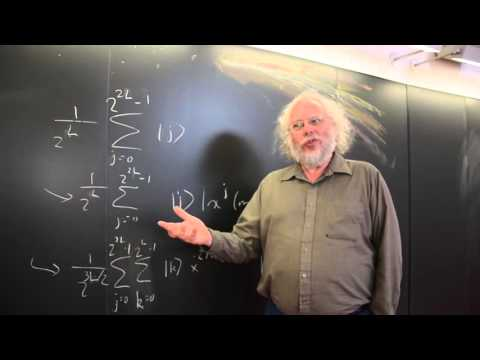

In [28]:
from IPython.display import YouTubeVideo
YouTubeVideo('hOlOY7NyMfs')

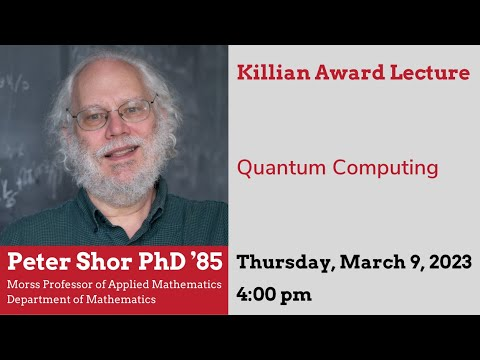

In [29]:
YouTubeVideo('d_5u2qdKoUU')

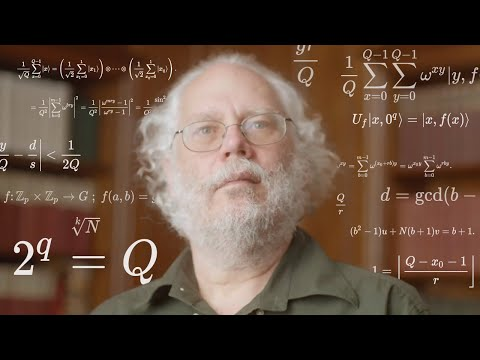

In [30]:
YouTubeVideo('6qD9XElTpCE')

As Peter Shor describes in the video above from [PhysicsWorld](http://physicsworld.com/cws/article/multimedia/2015/sep/30/what-is-shors-factoring-algorithm), Shor’s algorithm is composed of three parts. The first part turns the factoring problem into a period finding problem using number theory, which can be computed on a classical computer. The second part  finds the period using the quantum Fourier transform and is responsible for the quantum speedup of the algorithm. The third part uses the period found to calculate the factors.

### From Factorization to Period Finding

The number theory that underlines Shor's algorithm relates to periodic modulo sequences. Let's have a look at an example of such a sequence. Consider the sequence of the powers of two: 
$$1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 1024, ...$$
Now let's look at the same sequence 'modulo 15', that is, the remainder after fifteen divides each of these powers of two:
$$1, 2, 4, 8, 1, 2, 4, 8, 1, 2, 4, ...$$
This is a modulo sequence that repeats every four numbers, that is, a periodic modulo sequence with a period of four.

Reduction of factorization of $N$ to the problem of finding the period of an integer $x$ less than $N$ and greater than $1$ depends on the following result from number theory:

> The function $\mathcal{F}(a) = x^a \bmod N$ is a periodic function, where $x$ is an integer coprime to $N$ and $a \ge 0$.

Note that two numbers are coprime, if the only positive integer that divides both of them is 1. This is equivalent to their greatest common divisor being 1. For example, 8 and 15 are coprime, as they don't share any common factors (other than 1). However, 9 and 15 are not coprime, since they are both divisible by 3 (and 1). 

> Since $\mathcal{F}(a)$ is a periodic function, it has some period $r$. Knowing that $x^0 \bmod N = 1$, this means that $x^r \bmod N = 1$ since the function is periodic, and thus $r$ is just the first nonzero power where $x^r = 1 (\bmod N)$.

Given this information and through the following algebraic manipulation: 
$$ x^r \equiv 1 \bmod N $$
$$ x^r = (x^{r/2})^2 \equiv 1 \bmod N $$
$$ (x^{r/2})^2 - 1 \equiv 0 \bmod N $$
and if $r$ is an even number:
$$ (x^{r/2} + 1)(x^{r/2} - 1) \equiv 0 \bmod N $$

From this, the product $(x^{r/2} + 1)(x^{r/2} - 1)$ is an integer multiple of $N$, the number to be factored. Thus, so long as $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is not a multiple of $N$, then at least one of $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ must have a nontrivial factor in common with $N$. 

So computing $\text{gcd}(x^{r/2} - 1, N)$ and $\text{gcd}(x^{r/2} + 1, N)$ will obtain a factor of $N$, where $\text{gcd}$ is the greatest common denominator function, which can be calculated by the polynomial time [Euclidean algorithm](https://en.wikipedia.org/wiki/Euclidean_algorithm). 

#### Classical Steps to Shor's Algorithm

Let's assume for a moment that a period finding machine exists that takes as input coprime integers $a, N$ and outputs the period of $a \bmod N$, implemented by as a brute force search below. Let's show how to use the machine to find all prime factors of $N$ using the number theory described above. 

In [31]:
# Brute force period finding algorithm
def order_finding_classical(N,a):

    if (a < 2) or (a >= N):
        raise ValueError("The integer a must be in the range 2 <= a < N.")
    # check if a is a multiple of N
    if math.gcd(a, N) != 1:
        raise ValueError("The integer a must be coprime with N.")
    
    # find the smallest integer r such that a^r mod N = 1
    r = 1
    while a**r % N != 1:
        r += 1
    return r

For simplicity, assume that $N$ has only two distinct prime factors: $N = pq$.

<div class="alert alert-block alert-info"> <a id='stepsone'></a>
<ol>
<li>Pick a random integer $x$ between $1$ and $N$ and compute the greatest common divisor $\text{gcd}(x,N)$ using Euclid's algorithm.</li>
<li>If $x$ and $N$ have some common prime factors, $\text{gcd}(x,N)$ will equal $p$ or $q$. Otherwise $\text{gcd}(x,N) = 1$, meaning $x$ and $N$ are coprime. </li>
<li>Let $r$ be the period of $x \bmod N$ computed by the period finding machine. Repeat the above steps with different random choices of $x$ until $r$ is even.</li>
<li>Now $p$ and $q$ can be found by computing $\text{gcd}(x^{r/2} \pm 1, N)$ as long as $x^{r/2} \neq \pm 1$.</li>
</ol>
</div>

As an example, consider $N = 15$. Let's look at all values of $1 < x < 15$ where $x$ is coprime with $15$:

|  $x$  |         $x^a \bmod 15$       | Period $r$ |$\text{gcd}(x^{r/2}-1,15)$|$\text{gcd}(x^{r/2}+1,15)$ | 
|:-----:|:----------------------------:|:----------:|:------------------------:|:-------------------------:|
|   2   | 1,2,4,8,1,2,4,8,1,2,4...     |      4     |             3            |             5             |
|   4   | 1,4,1,4,1,4,1,4,1,4,1...     |      2     |             3            |             5             |
|   7   | 1,7,4,13,1,7,4,13,1,7,4...   |      4     |             3            |             5             |
|   8   | 1,8,4,2,1,8,4,2,1,8,4...     |      4     |             3            |             5             |
|   11  | 1,11,1,11,1,11,1,11,1,11,1...|      2     |             5            |             3             |
|   13  | 1,13,4,7,1,13,4,7,1,13,4,... |      4     |             3            |             5             |
|   14  | 1,14,1,14,1,14,1,14,1,14,1,,,|      2     |             1            |             15            |

As can be seen, any value of $x$ except $14$ will return the factors of $15$, that is, $3$ and $5$. $14$ is an example of the special case where $(x^{r/2} + 1)$ or $(x^{r/2} - 1)$ is a multiple of $N$ and thus another $x$ needs to be tried. 

In general, it can be shown that this special case occurs infrequently, so on average only two calls to the period finding machine are sufficient to factor $N$. 

For a more interesting example, first let's find larger number N, that is semiprime that is relatively small. Using the [Sieve of Eratosthenes](https://en.wikipedia.org/wiki/Sieve_of_Eratosthenes) [Python implementation](http://archive.oreilly.com/pub/a/python/excerpt/pythonckbk_chap1/index1.html?page=last), let's generate a list of all the prime numbers less than a thousand, randomly select two, and muliply them.

In [40]:
import random, itertools

# Sieve of Eratosthenes algorithm
def sieve( ):
    D = {  }
    yield 2
    for q in itertools.islice(itertools.count(3), 0, None, 2):
        p = D.pop(q, None)
        if p is None:
            D[q*q] = q
            yield q
        else:
            x = p + q
            while x in D or not (x&1):
                x += p
            D[x] = p

# Creates a list of prime numbers up to the given argument
def get_primes_sieve(n):
    return list(itertools.takewhile(lambda p: p<n, sieve()))

def get_semiprime(n):
    primes = get_primes_sieve(n)
    l = len(primes)
    p = primes[random.randrange(l)]
    q = primes[random.randrange(l)]
    return p*q

N = get_semiprime(1000)

print("semiprime N =",N)

semiprime N = 56561


In [41]:
def shors_algorithm_classical(N):
    x = random.randint(0,N) # step one
    if(math.gcd(x,N) != 1): # step two
        return x,0,math.gcd(x,N),N/math.gcd(x,N)
    r = find_period_classical(x,N) # step three
    while(r % 2 != 0):
        r = find_period_classical(x,N)
    p = math.gcd(x**int(r/2)+1,N) # step four, ignoring the case where (x^(r/2) +/- 1) is a multiple of N
    q = math.gcd(x**int(r/2)-1,N)
    return x,r,p,q

x,r,p,q = shors_algorithm_classical(N)
print("semiprime N = ",N,", coprime x = ",x,", period r = ",r,", prime factors = ",p," and ",q,sep="")

semiprime N = 56561, coprime x = 31805, period r = 28026, prime factors = 56561 and 1


### Quantum Period Finding <a id='quantumperiodfinding'></a>

Let's first describe the quantum period finding algorithm, and then go through a few of the steps in detail, before going through an example. This algorithm takes two coprime integers, $x$ and $N$, and outputs $r$, the period of $\mathcal{F}(a) = x^a\bmod N$.

<div class="alert alert-block alert-info"><a id='stepstwo'></a>
<ol>
<li> Choose $T = 2^t$ such that $N^2 \leq T \le 2N^2$. Initialise two registers of qubits, first an argument register with $t$ qubits and second a function register with $n = log_2 N$ qubits. These registers start in the initial state:
$$\vert\psi_0\rangle = \vert 0 \rangle \vert 0 \rangle$$ </li>
<li> Apply a Hadamard gate on each of the qubits in the argument register to yield an equally weighted superposition of all integers from $0$ to $T$:
$$\vert\psi_1\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert 0 \rangle$$ </li>
<li> Implement the modular exponentiation function $x^a \bmod N$ on the function register, giving the state:
$$\vert\psi_2\rangle = \frac{1}{\sqrt{T}}\sum_{a=0}^{T-1}\vert a \rangle \vert x^a \bmod N \rangle$$
This $\vert\psi_2\rangle$ is highly entangled and exhibits quantum parallism, i.e. the function entangled in parallel all the 0 to $T$ input values with the corresponding values of $x^a \bmod N$, even though the function was only executed once. </li>
<li> Perform a quantum Fourier transform on the argument register, resulting in the state:
$$\vert\psi_3\rangle = \frac{1}{T}\sum_{a=0}^{T-1}\sum_{z=0}^{T-1}e^{(2\pi i)(az/T)}\vert z \rangle \vert x^a \bmod N \rangle$$
where due to the interference, only the terms $\vert z \rangle$ with
$$z = qT/r $$
have significant amplitude where $q$ is a random integer ranging from $0$ to $r-1$ and $r$ is the period of $\mathcal{F}(a) = x^a\bmod N$. </li>
<li> Measure the argument register to obtain classical result $z$. With reasonable probability, the continued fraction approximation of $T / z$ will be an integer multiple of the period $r$. Euclid's algorithm can then be used to find $r$.</li>
</ol>
</div>

Note how quantum parallelism and constructive interference have been used to detect and measure periodicity of the modular exponentiation function.  The fact that interference makes it easier to measure periodicity should not come as a big surprise. After all, physicists routinely use scattering of electromagnetic waves and interference measurements to determine periodicity of physical objects such as crystal lattices. Likewise, Shor's algorithm exploits interference to measure periodicity of arithmetic objects, a computational interferometer of sorts. 

In [5]:
# Check if a is coprime with N
while math.gcd(a,N)!=1:
    a=np.random.randint(1,N)

print(f"Chosen a={a} such that it is coprime with N={N}")

Chosen a=54031 such that it is coprime with N=62208


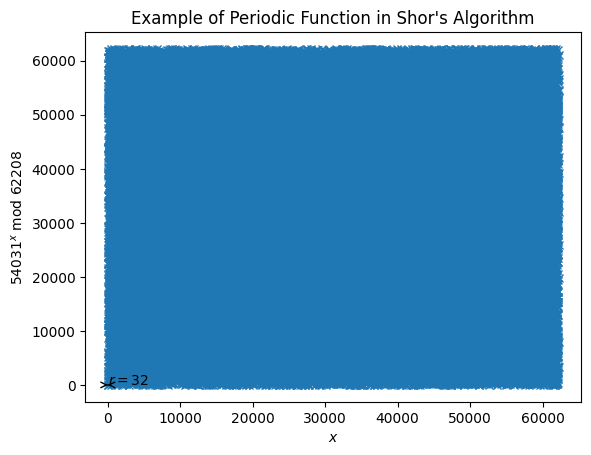

In [6]:
# Calculate the plotting data
xvals = np.arange(N)
yvals = [np.mod(a**x, N) for x in xvals]

# Use matplotlib to display it nicely
fig, ax = plt.subplots()
ax.plot(xvals, yvals, linewidth=1, linestyle='dotted', marker='x')
ax.set(xlabel='$x$', ylabel=f'${a}^x$ mod ${N}$',
       title="Example of Periodic Function in Shor's Algorithm")
try: # plot r on the graph
    r = yvals[1:].index(1) + 1
    plt.annotate('', xy=(0,1), xytext=(r,1),
                 arrowprops=dict(arrowstyle='<->'))
    plt.annotate(f'$r={r}$', xy=(r/3,1.5))
except ValueError:
    print('Could not find period, check a < N and have no common factors.')

## Step 1: Map classical inputs to a quantum problem

The Shor's algorithm first checks if $N$ is even or a prime number. If it is even, then it returns the factor of $N/2$ and $2$.

In [7]:
# Check if N=a^b for some a and b
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for _ in range(j):
        a = np.mod(a**2, N)
    return a

In [ ]:
def orderfinding(N,a):
    # Create QuantumCircuit
    n_count = 8
    n_count2 = 3
    a = a
    N = N
    a = a % N
    # Create QuantumCircuit
    qc = QuantumCircuit(n_count + n_count2, n_count)
    # Apply H-gates
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(n_count2) # And auxiliary register in state |1>
    qc.h(n_count2)
    # Do controlled-U operations
    for q in range(n_count):
        for _ in range(2**q):
            qc.cp(2*np.pi*a2jmodN(a, 2**(n_count-1-q), N), q, n_count)
    # Apply inverse QFT
    qc.append(QFT(n_count, insert_barriers=False, do_swaps=False, inverse=True), range(n_count))
    # Measure circuit
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    job = backend.run(qc, shots=1, optimization_level=3)
    result = job.result()
    counts = result.get_counts()
    return counts

In [8]:
def Shor(N):
    # Check if $N$ is even
    factors={}
    while N%2==0:
        if 2 not in factors:
            factors[2]=0
        factors[2]+=1
        N=N//2
               

    if N!=1:
        log2n=math.log2(N)

        for b in range(2,math.floor(log2n)+1):
            x=log2n/b
            
            u_1=math.floor(2**x)
            u_2=math.ceil(2**x)

            if u_1**b==N:
                factors[u_1]=b
                break
            elif u_2**b==N:
                factors[u_2]=b
                break
            else:
                continue
    
            


        
    
    return factors



In [ ]:
N=3**5*2**8
a=np.random.randint(1,N)
factors = Shor(N)

In [10]:
print(factors)

{2: 8, 3: 5}
